### Utils

In [244]:
import random
from typing import List
from gxgp.node import Node
from utils.operations_dict import basic_function_set, complex_function_set

# If updates on imported files aren't detected, restart the kernel (we'll need to find an automatic solution for this)

import numpy as np
from icecream import ic

from typing import List, Tuple, Dict

In [245]:
def generate_random_tree(max_height: int, pc: float, terminal_list: List[str],
                         constants: list[float] = None, p_pick_constant: float = 0.2, p_cut_tree: float = 0.2,
                         verbose: bool = False, cur_depth: int = 0) -> Node:
    """
    Generate a random symbolic expression tree.

    Mandatory Parameters
    ----------
    max_height : int
        The maximum height of the tree. The height of a tree is the length of the longest path from the root to a leaf (e.g. height of a leaf is 0).
    pc : float
        The probability of choosing a complex function over a basic function.
    terminal_list : List[str]
        The terminal list to choose from. Example: ['x0', 'x1', 'x2']

    Optional Parameters
    ----------
    constants : list[float]
        A list of constants that can be used in the tree (default is None).
    p_pick_constant : float
        The probability of choosing a constant over a terminal (default is 0.2).
    p_cut_tree : float
        The probability of cutting the tree early (default is 0.2).    
    verbose : bool    
        Whether to print debug information (default is False).
    cur_depth : int
        The exploration depth (e.g. depth of root is 0)

    Returns
    -------
    Node
        A Node object representing the root of the tree.
    """
    indent = ' ' * (cur_depth * 2)

    # Cut the tree early with probability 0.2
    if (random.random() < p_cut_tree) or max_height == 0:  
        # If constants are provided, choose one with probability p_pick_constant
        if constants is not None and random.random() < p_pick_constant: 
            terminal = random.choice(constants) 
        # Otherwise, pick from the terminal set
        else:                                                
            terminal = random.choice(terminal_list)
        
        if verbose: print(f"{indent}Picked terminal: {terminal}")

        # Set the height of the node to 0
        my_node = Node(terminal)
        my_node.set_height(0)
        return my_node
    else:
        # Choose a complex function with probability pc
        if random.random() < pc:                       
            func = random.choice(list(complex_function_set.keys()))
            if verbose: print(f"{indent}Chose complex function {func}")
            num_children = complex_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1)
                        for _ in range(num_children)]
            
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(complex_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node
        # Otherwise, choose a basic function
        else:                                           
            func = random.choice(list(basic_function_set.keys()))
            if verbose: print(f"{indent}Chose basic function {func}")
            num_children = basic_function_set[func].__code__.co_argcount  # Numero di argomenti della funzione
            children = [generate_random_tree(max_height - 1, pc, terminal_list, constants, p_pick_constant, p_cut_tree, verbose, cur_depth + 1)
                        for _ in range(num_children)]
            # Set height
            cur_height = max([child.get_height() for child in children]) + 1
            my_node = Node(basic_function_set[func], children, name=func)
            my_node.set_height(cur_height)
            return my_node

In [246]:
# Fitness reverse
def fitness(mytree: Node, vars, labels, verbose=False):
    try:
        output = np.array([mytree(**var) for var in vars])
        if mytree.get_height() > 0:
            mse = 100 * np.square(labels - output).mean()
            mse += mse * 0.01 * mytree.get_height()
        else:
            mse = 100 * np.square(labels - output).mean()
        return mse
    except RuntimeWarning as e:
        if verbose: print(f"caught runtime warning: {e}, setting fitness to inf")
        return np.inf

#print(fitness(initialized, vars, labels))

### Init

In [248]:
from gxgp import Node
import numpy as np

problem_number = 6
problem = np.load(f'./data/problem_{problem_number}.npz')
input = problem['x']
labels = problem['y']

print("Input shape:", input.shape, " Example of sample: ", input[:, 0])
print("Labels shape:", labels.shape, " Example of label: ", labels[0])

# Terminal set
terminal_list = ['x' + str(i) for i in range(input.shape[0])]

print("terminal_list: ", terminal_list)

print("input shape is ", input.shape)

vars = []
for j in range(input.shape[1]):
    cur_vars = {'x'+str(i): input[i][j] for i in range(input.shape[0])}
    # print("cur_vars is ", cur_vars)
    vars.append(cur_vars)
vars = np.array(vars)

print("vars shape is ", vars.shape)

Input shape: (2, 5000)  Example of sample:  [ 1.00178758 -1.98101753]
Labels shape: (5000,)  Example of label:  -4.052636527634054
terminal_list:  ['x0', 'x1']
input shape is  (2, 5000)
vars shape is  (5000,)


Chose basic function sqrt
  Chose basic function add
    Chose complex function log
      Picked terminal: x1
    Chose complex function neg
      Picked terminal: x1
Drawing tree with height 3...


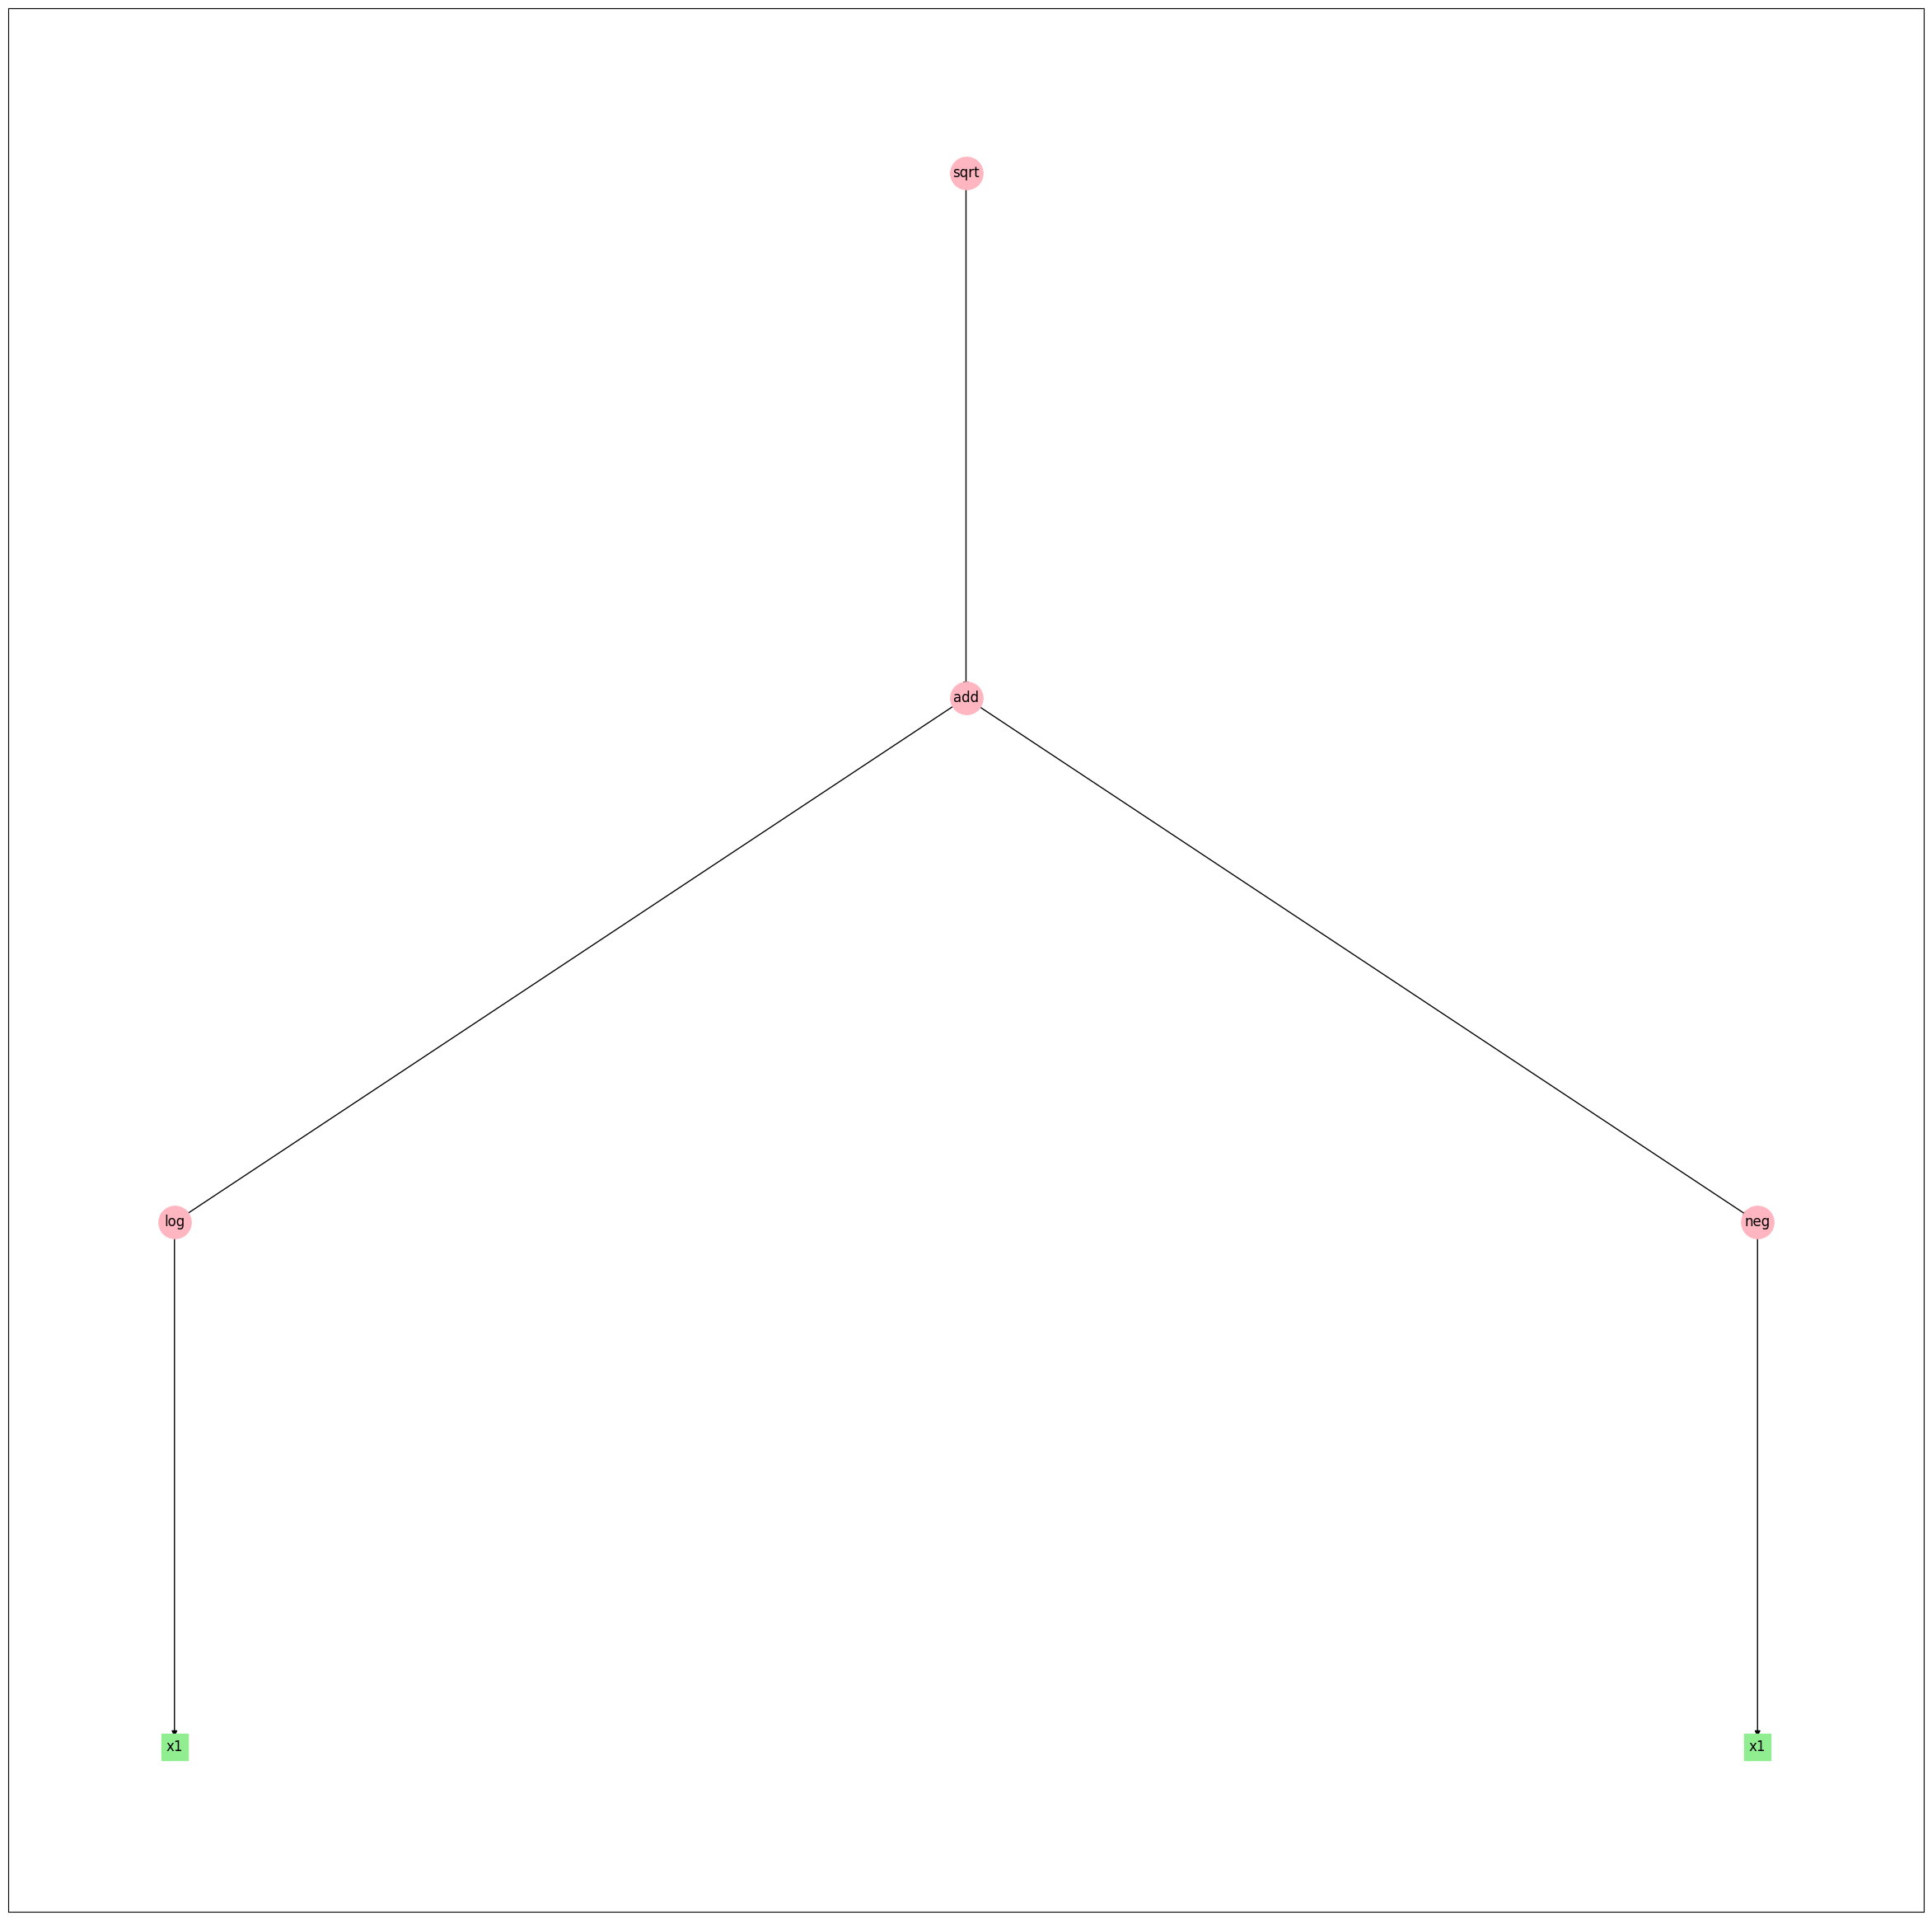

In [249]:
from utils.terminal_constants import crammed_constants

height = 3
my_tree = generate_random_tree(height, 0.2, terminal_list, constants=crammed_constants, p_pick_constant=0.4, p_cut_tree=0.01, verbose=True)
my_tree.draw()

### Test

In [250]:
function_as_string = str(my_tree)
print("Function as string: ", function_as_string)


Function as string:  sqrt(add(log(x1), neg(x1)))


In [251]:
print(input)

[[ 1.00178758  0.44006354 -0.11625375 ...  3.90090504  1.33256966
   1.29138973]
 [-1.98101753 -1.36394591 -2.97640047 ... -4.58955249 -2.90251977
  -2.19778837]]


In [321]:
import numpy as np
def my_sqrt(x: np.ndarray) -> np.ndarray:
    return np.sqrt(np.abs(x))

def my_log(x: np.ndarray) -> np.ndarray:
    return np.log(np.abs(x))

def my_reciprocal(x: np.ndarray) -> np.ndarray:
    if not isinstance(x, np.ndarray):
        if x == 0:
            return 0
        else:
            return np.reciprocal(x)
        
    out = []
    for el in x:
        if el == 0:
            out.append(el)
        else:
            out.append(np.reciprocal(el))
    return np.array(out)

In [322]:
def f6(x: np.ndarray) -> np.ndarray:
    return np.subtract(np.add(np.add(x[1], x[1]), np.abs(np.subtract(np.add(my_sqrt(np.add(np.subtract(np.subtract(np.subtract(np.add(np.add(x[0], x[1]), np.abs(np.subtract(np.subtract(6, 6), np.add(np.subtract(np.sin(np.subtract(my_sqrt(np.add(my_sqrt(my_reciprocal(my_sqrt(np.subtract(6, 6)))), my_sqrt(x[0]))), x[1])), np.add(np.add(my_sqrt(x[0]), np.multiply(np.subtract(np.subtract(np.add(np.add(x[0], x[1]), np.abs(np.subtract(np.subtract(6, 6), my_sqrt(np.add(np.add(my_sqrt(x[1]), np.multiply(np.subtract(x[1], x[1]), np.subtract(np.sin(np.subtract(x[1], x[1])), np.add(np.add(my_sqrt(np.add(x[1], np.multiply(np.subtract(x[1], x[1]), np.add(6, x[0])))), np.multiply(np.subtract(np.divide(np.sin(np.subtract(10, x[1])), x[1]), np.multiply(np.sin(np.subtract(x[1], x[1])), np.add(my_sqrt(my_reciprocal(my_sqrt(np.subtract(np.abs(x[1]), 6)))), my_sqrt(x[0])))), x[1])), x[1])))), np.multiply(np.sin(np.subtract(x[1], x[1])), np.add(my_sqrt(my_reciprocal(my_sqrt(x[1]))), my_sqrt(x[0])))))))), x[0]), x[1]), x[1])), np.multiply(np.sin(x[1]), np.divide(np.multiply(np.subtract(x[1], x[1]), np.add(6, x[1])), np.abs(x[0]))))), x[1])))), x[0]), x[1]), x[1]), x[0])), np.multiply(np.subtract(x[1], x[1]), np.add(6, np.add(x[1], x[1])))), my_sqrt(np.add(np.add(my_sqrt(np.add(np.subtract(np.sin(np.subtract(x[1], x[1])), np.add(np.add(my_sqrt(x[0]), np.multiply(np.subtract(np.subtract(np.add(np.add(x[0], x[1]), np.abs(np.subtract(np.subtract(6, 6), my_sqrt(np.add(my_sqrt(x[0]), np.multiply(np.sin(x[1]), np.multiply(np.subtract(x[1], x[1]), np.add(6, x[1])))))))), x[0]), x[1]), x[1])), np.multiply(np.sin(np.subtract(x[1], x[1])), 6))), x[1])), np.multiply(np.subtract(x[1], x[1]), np.add(np.multiply(np.sin(np.subtract(x[1], x[1])), my_sqrt(x[1])), x[1]))), np.multiply(np.sin(np.subtract(x[1], x[1])), np.add(my_sqrt(my_reciprocal(my_sqrt(np.subtract(np.abs(x[1]), 6)))), my_sqrt(np.add(np.add(x[0], x[1]), np.abs(np.subtract(np.subtract(6, 6), my_sqrt(np.add(my_sqrt(x[0]), np.multiply(np.sin(x[1]), np.multiply(np.subtract(x[1], x[1]), 6))))))))))))))), x[0])# Resulting fitness

tree_output = [my_tree(**var) for var in vars]
tree_output = [(float(out)) for out in tree_output]

# print(f"shape of input is {input.shape}")

# str_output = f6(input)
# str_output = [(float(out)) for out in str_output]
# for str_out, tree_out in zip(str_output, tree_output):
#     print(f"str_out is {str_out}")

print(f"MSE (train): {100*np.square(labels-f6(input)).sum()/len(labels):g}")

MSE (train): 8.80888
